In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, l2, create_gif, clear_temp
from modules.problems import oscillator

import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
import torch.nn as nn

class SinActivation(nn.Module):
    def __init__(self, alpha=1, learnable=False):
        super(SinActivation, self).__init__()
        if learnable:
            self.alpha = nn.Parameter(torch.as_tensor(alpha))
        else:
            self.alpha = alpha
    def forward(self, x):
        return torch.sin(x)
    
class Swish(nn.Module):
    def __init__(self, beta=1, learnable=False):
        super(Swish, self).__init__()
        if learnable:
            self.beta = nn.Parameter(torch.as_tensor(beta))
        else:
            self.beta = beta
    def forward(self, x):
        return x * nn.functional.sigmoid(self.beta * x)

In [8]:
def f(problem, N_F, loss_history=None):
    zero = torch.tensor([0.], requires_grad=True).to(device)
    t = torch.linspace(0, problem.T, N_F, requires_grad=True).reshape(-1, 1)
    return zero, t

problem = None
name = None
activation = None

def objective(trial):

    L, W = 2, 32
    model = FeedForwardNetwork(L, W, activation=activation)
    
    coef = trial.suggest_float('coef', 0.05, 0.95)
    lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
    N_F = trial.suggest_int('NF', 1024, 2048, step=512)

    result = problem.train(
        model,
        hyperparameters={
            'optimizer': torch.optim.Adam,
            'arguments': {'lr': lr},
            'scheduler': {
                'rule': torch.optim.lr_scheduler.StepLR,
                'parameters': {'step_size': 10000}
                },
            'num_iters': 7500,
            'collocation_points': {
                'sample_every': 0,
                'N_points': {'N_F': N_F},
                'generation_function': f
            },
            'coefs': [[coef], [1 - coef]],
            'dynamic_coefs': -1,
            'coef_func': None
        },
        logging_params={
        'loss':  50,
        'norms': 50,
        'error': 50,
        'steps': 50,
        'log_dir': f'./logging/{name}_{trial.number}.json'
        },
        name=name,
        show_progress=False
    )
    
    return result['final_error']

In [9]:
import optuna

activation_functions = [nn.Tanh(), SinActivation(), Swish()]
activation_names = ['tanh', 'sin', 'swish']

for problem_number in [1, 2, 3, 4]:
    problem = oscillator.DampedHarmonicOscillator.get_problem(problem_number)
    for activ_name, activ_func in zip(activation_names, activation_functions):
        name = f'dho{problem_number}_{activ_name}'
        activation = activ_func

        study = optuna.create_study(study_name=name, direction='minimize', sampler=optuna.samplers.GPSampler(n_startup_trials=5))
        study.optimize(objective, n_trials=15)
        
        study.trials_dataframe().to_csv(f'./studies/{study.study_name}.csv', sep=',')

C:\Temp\ipykernel_10956\3347617693.py:12: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(study_name=name, direction='minimize', sampler=optuna.samplers.GPSampler(n_startup_trials=5))
[I 2024-04-16 19:41:55,751] A new study created in memory with name: dho1_tanh
Iter   788 	 4.168194420617455:  11%|█         | 789/7500 [00:30<01:28, 76.08it/s][I 2024-04-16 19:43:04,249] Trial 0 finished with value: 0.94241804784501 and parameters: {'coef': 0.24344066534380682, 'lr': 0.018930556719432376, 'NF': 1536}. Best is trial 0 with value: 0.94241804784501.
[I 2024-04-16 19:44:12,897] Trial 1 finished with value: 1.2824252079383822 and parameters: {'coef': 0.2628563597406133, 'lr': 0.002137369213200958, 'NF': 1536}. Best is trial 0 with value: 0.94241804784501.
[I 2024-04-16 19:45:18,279] Trial 2 finished with value: 1.6777969872543526 and parameters: {'coef': 0.328550151672515, 'lr': 0.001730830429141859

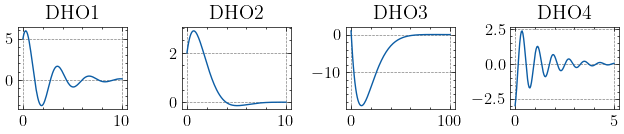

In [ ]:
problems = [oscillator.DampedHarmonicOscillator.get_problem(i) for i in range(1, 5)]

size = (3.5, 3)
fig, axs = plt.subplots(2, 2, figsize=size)
for (i, j), (ind, problem) in zip([(0, 0), (0, 1), (1, 0), (1, 1)], enumerate(problems)):
    axs[i, j].plot(problem.domain, problem.solution)
    
plt.tight_layout()

plt.savefig('../images/dho_grid_2.png', dpi=250)
plt.show()